<a href="https://colab.research.google.com/github/Vish4github/Projects/blob/master/News%20Category%20Classification%20Using%20Transfer%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install fastai==0.7.0

In [0]:
!pip3 install torchvision
!pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

In [0]:
from fastai.imports import *

In [0]:
from torch import * 
!pip install Pillow==4.1.1
!pip install image
%matplotlib inline
from fastai.imports import *

In [0]:
!pip install "torchtext==0.2.3"

In [0]:
!pip3 install spacy 
!python -m spacy download en

In [0]:
!nvcc --version

In [12]:
import torch
torch.cuda.is_available()
#torch.backends.cudnn.enabled
#!nvidia-smi
#!python --version

True

In [0]:
#!pip install fastai
!pip install fastai --upgrade


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.text import *
from fastai.text import Tokenizer, Vocab
from keras.preprocessing.text import Tokenizer, text_to_word_sequence

Using TensorFlow backend.


In [1]:
import numpy as np
import pandas as pd
import re
import string
import pickle
import time
import sys
#!{sys.executable} -m spacy download en
import math
from pprint import pprint
import warnings
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score ,confusion_matrix

# Gensim
import gensim, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

# NLTK
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('movie_reviews')

#tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=0.05, stop_words="english")

# SpaCy
import spacy
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [2]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/Data/News_Category_Dataset_v2.json"
df =  pd.read_json(path,lines=True)
df.head()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [3]:
cates = df.groupby('category')
print("total categories:", cates.ngroups)
print(cates.size())

total categories: 41
category
ARTS               1509
ARTS & CULTURE     1339
BLACK VOICES       4528
BUSINESS           5937
COLLEGE            1144
COMEDY             5175
CRIME              3405
CULTURE & ARTS     1030
DIVORCE            3426
EDUCATION          1004
ENTERTAINMENT     16058
ENVIRONMENT        1323
FIFTY              1401
FOOD & DRINK       6226
GOOD NEWS          1398
GREEN              2622
HEALTHY LIVING     6694
HOME & LIVING      4195
IMPACT             3459
LATINO VOICES      1129
MEDIA              2815
MONEY              1707
PARENTING          8677
PARENTS            3955
POLITICS          32739
QUEER VOICES       6314
RELIGION           2556
SCIENCE            2178
SPORTS             4884
STYLE              2254
STYLE & BEAUTY     9649
TASTE              2096
TECH               2082
THE WORLDPOST      3664
TRAVEL             9887
WEDDINGS           3651
WEIRD NEWS         2670
WELLNESS          17827
WOMEN              3490
WORLD NEWS         2177
WORLDPOST 

Some of the above categories can be combined under a broader umbrella - comdey and entertainment ; style and style & beauty etc

In [4]:
df.loc[(df.category =='WORLD NEWS')][['headline','short_description','category']].tail()

,headline,short_description,category
26030,The Riyadh Summits: A Workshop For A Global Fr...,Donald Trump’s presidency is currently undergo...,WORLD NEWS
26039,Donald Of Arabia,"If Trump continues on this path, the future is...",WORLD NEWS
26047,Resistance Grows Against Hungarian Government'...,Budapest is seeing its largest anti-government...,WORLD NEWS
26109,Trump’s Counter-Extremism Effort Should Addres...,The president will have to address incitement ...,WORLD NEWS
29757,What You Need To Know About North Korea's Nucl...,Experts say the country's nuclear weapons test...,WORLD NEWS


In [5]:
df.loc[(df.category =='WORLDPOST')][['headline','short_description','category']].head()

,headline,short_description,category
34622,A New American Strategy in the Middle East,,WORLDPOST
34626,Islamic Republic of Iran's Lobbyists and Spies...,,WORLDPOST
34704,Brexit And Northern Ireland: Fact vs. Fiction,"Since the Brexit referendum last summer, there...",WORLDPOST
34705,Leave No Person With Disabilities Behind,I am one of many in Bangladesh and around the ...,WORLDPOST
34719,How to Put America First--While Engaging the R...,,WORLDPOST


In [6]:
df.loc[(df.category =='LATINO VOICES')][['headline','short_description','category']].tail()

,headline,short_description,category
124413,LOOK: Latin Billboard Music Awards Fashion Hit...,,LATINO VOICES
124434,Are Deportations Rising or Falling? A Focus on...,Although clear and correct statistics are no d...,LATINO VOICES
124624,When I Chose to Stop Feeling Small: The Story ...,"No woman in my family had ever been this tall,...",LATINO VOICES
124644,More Latino Than White Students Admitted To UC,,LATINO VOICES
124667,Living and Breathing Gabriel García Márquez,Thirty years ago I lived García Márquez. Maybe...,LATINO VOICES


In [0]:
df.category = df.category.map(lambda x: "WORLD NEWS" if x == "THE WORLDPOST" else x)
df.category = df.category.map(lambda x: "ENVIRONMENT" if x == "GREEN" else x)
df.category = df.category.map(lambda x: "ARTS & CULTURE" if x == "CULTURE & ARTS" else x)
df.category = df.category.map(lambda x: "ENTERTAINMENT" if x == "COMEDY" else x)
df.category = df.category.map(lambda x: "EDUCATION" if x == "COLLEGE" else x)
df.category = df.category.map(lambda x: "FOOD & DRINK" if x == "TASTE" else x)
df.category = df.category.map(lambda x: "HEALTHY LIVING" if x == "WELLNESS" else x)
df.category = df.category.map(lambda x: "STYLE & BEAUTY" if x == "STYLE" else x)
df.category = df.category.map(lambda x: "PARENTS" if x == "PARENTING" else x)
df.category = df.category.map(lambda x: "WORLD NEWS" if x == "WORLDPOST" else x)

We have reduced the category dimensions from 41 to 31 

In [8]:
cates = df.groupby('category')
print("total categories:", cates.ngroups)
print(cates.size())

total categories: 31
category
ARTS               1509
ARTS & CULTURE     2369
BLACK VOICES       4528
BUSINESS           5937
CRIME              3405
DIVORCE            3426
EDUCATION          2148
ENTERTAINMENT     21233
ENVIRONMENT        3945
FIFTY              1401
FOOD & DRINK       8322
GOOD NEWS          1398
HEALTHY LIVING    24521
HOME & LIVING      4195
IMPACT             3459
LATINO VOICES      1129
MEDIA              2815
MONEY              1707
PARENTS           12632
POLITICS          32739
QUEER VOICES       6314
RELIGION           2556
SCIENCE            2178
SPORTS             4884
STYLE & BEAUTY    11903
TECH               2082
TRAVEL             9887
WEDDINGS           3651
WEIRD NEWS         2670
WOMEN              3490
WORLD NEWS         8420
dtype: int64


Clean module

In [0]:
lemma = WordNetLemmatizer()
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
def clean_text(text):
    lower = text.lower()
    # Split into list
    wordList = lower.split()
    # Remove punctuation
    wordList_punc = ["".join(i for i in word if (i=="'")|(i not in string.punctuation)) for word in wordList]
    # Remove stopwords
    wordList_stop = [word for word in wordList_punc if word not in list(spacy_stopwords)]
    # Remove other keywords
    #wordList_key = [word for word in wordList_stop if word not in keywords]
    # Stemming
    #words_stemmed= [stemmer.stem(word) for word in wordList_key]
    # Lemmatisation
    #lemma_word = nlp(wordList)
    wordList_clean = [lemma.lemmatize(word) for word in wordList_stop]
    #wordList = [word.lemma_ for word in wordList]
    return " ".join(wordList_clean)


In [10]:
%%time
df['Clean_headline'] = df.headline.map(clean_text)
df['Clean_description'] = df.short_description.map(clean_text)

CPU times: user 56 s, sys: 126 ms, total: 56.1 s
Wall time: 56.1 s


In [11]:
df.head()

,category,headline,authors,link,short_description,date,Clean_headline,Clean_description
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,2 mass shooting texas week 1 tv,left husband killed child day america
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,smith join diplo nicky jam 2018 world cup's of...,course song
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,hugh grant marries time age 57,actor longtime girlfriend anna eberstein tied ...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,jim carrey blast 'castrato' adam schiff democr...,actor give dems asskicking fighting hard donal...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,julianna margulies us donald trump poop bag pi...,dietland actress said bag cathartic therapeuti...


In [0]:
# using headlines and short_description as input X

df['text'] = df.headline + " " + df.short_description
df['text_cleaned'] = df.Clean_headline + " " + df.Clean_description

In [0]:
# Split the data into train and test.
X_train, X_test, Y_train, Y_test = train_test_split(df['text_cleaned'], df['category'], test_size=0.33)

In [0]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df = 5)

tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [15]:
tfidf_train.shape

(134571, 60412)

In [16]:
%%time
from sklearn.svm import LinearSVC

model = LinearSVC()
model.fit(tfidf_train,Y_train)
Y_predict = model.predict(tfidf_test)
accuracy = accuracy_score(Y_test,Y_predict)*100
print('The accuracy of SVM is', format(accuracy, '.2f'))

The accuracy of SVM is 67.72
CPU times: user 17.5 s, sys: 9.05 ms, total: 17.5 s
Wall time: 17.5 s


In [17]:
%%time

logistic_Regression = LogisticRegression()
logistic_Regression.fit(tfidf_train,Y_train)
Y_predict = logistic_Regression.predict(tfidf_test)
accuracy = accuracy_score(Y_test,Y_predict)*100
print('The accuracy of Logistic Regression is', format(accuracy, '.2f'))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


The accuracy of Logistic Regression is 66.70
CPU times: user 1min 36s, sys: 33 s, total: 2min 9s
Wall time: 1min 27s


In [18]:
%%time
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
model.fit(tfidf_train, Y_train)
prediction_knn = model.predict(tfidf_test)
accuracy = accuracy_score(prediction_knn,Y_test)*100
print('The accuracy of KNeighbours Classifier is', format(accuracy, '.2f'))

The accuracy of KNeighbours Classifier is 14.41
CPU times: user 3min 4s, sys: 1.07 s, total: 3min 5s
Wall time: 3min 5s


In [19]:
%%time

from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(tfidf_train, Y_train)
prediction_decision_tree = model.predict(tfidf_test)
accuracy = accuracy_score(prediction_decision_tree,Y_test)*100
print('The accuracy of Decision Tree is', format(accuracy, '.2f'))

The accuracy of Decision Tree is 48.46
CPU times: user 4min 41s, sys: 41.3 ms, total: 4min 41s
Wall time: 4min 42s


In [20]:
%%time

from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB(alpha=0.1)
model.fit(tfidf_train,Y_train)
Y_predict = model.predict(tfidf_test)
accuracy = accuracy_score(Y_predict,Y_test)*100
print('The accuracy of Naive Bayes is',format(accuracy, '.2f'))

The accuracy of Naive Bayes is 64.14
CPU times: user 1.85 s, sys: 5.07 ms, total: 1.86 s
Wall time: 1.86 s


Preprocessing for Transfer Learning model

In [0]:
# tokenizing
tokenizer = Tokenizer()
#tokenizer.process_text(df.text)
tokenizer.fit_on_texts(df.text)
X = tokenizer.texts_to_sequences(df.text)
df['words'] = X

# delete some empty and short data

df['word_length'] = df.words.apply(lambda i: len(i))
df = df[df.word_length >= 5]

In [176]:
df.head()
df = df.drop(df.columns[[1,2,3,4,5,6,7,9,10,11]], axis=1)
df.shape

(199914, 2)

In [0]:
df.to_csv('/content/drive/My Drive/Data/cleaned.csv',encoding='utf-8')

In [3]:
df2 = pd.read_csv('/content/drive/My Drive/Data/cleaned.csv')
df2.head()

,Unnamed: 0,category,text
0,0,CRIME,There Were 2 Mass Shootings In Texas Last Week...
1,1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...
2,2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 5...
3,3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...


In [5]:
df2 = pd.read_csv('/content/drive/My Drive/Data/cleaned.csv')
df3 = df2
df3.head()

X=df3.sample(frac=0.85,random_state=200)
test=df3.drop(X.index)
train=X.sample(frac=0.85,random_state=200)
val=X.drop(train.index)

print(train.shape)
print(val.shape)
print(test.shape)
train.to_csv('/content/drive/My Drive/Data/train.csv',encoding='utf-8',index=False)
val.to_csv('/content/drive/My Drive/Data/val.csv',encoding='utf-8',index=False)
test.to_csv('/content/drive/My Drive/Data/test.csv',encoding='utf-8',index=False)

df3.head()

(144438, 3)
(25489, 3)
(29987, 3)


,Unnamed: 0,category,text
0,0,CRIME,There Were 2 Mass Shootings In Texas Last Week...
1,1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...
2,2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 5...
3,3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...


In [0]:
train_df=pd.read_csv('/content/drive/My Drive/Data/train.csv')
train_df=train_df[['category','text']]

In [0]:
valid_df=pd.read_csv('/content/drive/My Drive/Data/val.csv')
valid_df=valid_df[['category','text']]

In [8]:
#from sklearn.model_selection import train_test_split
#train_df,valid_df=train_test_split(df_text, shuffle=True, test_size=0.25)
len(train_df),len(valid_df)

(144438, 25489)

In [9]:
train_df.head(),valid_df.head()

(         category                                               text
 0    FOOD & DRINK  Luke From 'Gilmore Girls' Is Getting His Own L...
 1            TECH  The Huffington Post Is Hiring A Tech Reporter ...
 2    FOOD & DRINK  Simple Greek: Baked Sardines From Diane Kochil...
 3  HEALTHY LIVING  Political Workout Music For The Convention Glu...
 4    BLACK VOICES  AP Uses Jordan Peele Photo While Tweeting Abou...,
          category                                               text
 0        BUSINESS  ‘Nobody Speak’: How Billionaires Are Silencing...
 1  HEALTHY LIVING  This Couple's Biggest Adventure Began When The...
 2      WORLD NEWS  An Interview With Former President Of The EU P...
 3          TRAVEL  5 Things You Must Do Before You File Your Trav...
 4  STYLE & BEAUTY  28 Valentine's Day Nail Art Ideas To Put You I...)

In [0]:
bs,bptt=64,60

A text is,unlike images which can be fed directly into a model, is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them to numbers. This is done in two differents steps: tokenization and numericalization. A TextDataBunch does all of that behind the scenes.

In [11]:
# Language model data
data_lm = TextLMDataBunch.from_df(path,train_df=train_df,valid_df=valid_df,text_cols='text', label_cols='category',bs=bs)

# Classification model data
data_clas = TextClasDataBunch.from_df(path, train_df=train_df,valid_df=valid_df, vocab=data_lm.train_ds.vocab, text_cols = 'text', label_cols = 'category',bs=bs)


Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used ( Vocab or dictionary). We only keep the ones that appear atleast twice with a maximum vocabulary size of 60,000 (by default) and the ones that don't make the cut are tagged as UNK

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used ( Vocab or dictionary). We only keep the ones that appear atleast twice with a maximum vocabulary size of 60,000 (by default) and the ones that don't make the cut are tagged as UNK

.itos and .stoi will give us information on how our tokens and numericalized and stored 

In [13]:
data_lm.vocab.itos[:10]  # first 10 tokens in our vocab

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

In [14]:
data_lm.vocab.itos[448]

'weight'

In [15]:
data_lm.train_ds[0][0].data[:10]  # first sentence in our training dataset

array([   2,    5, 5112,    5,   42,   21,    5, 8016,    5,  478])

In [16]:
len(data_lm.vocab.itos),len(data_lm.train_ds)

(48368, 144438)

In [17]:
data_clas.show_batch()  # shows a portion of the data loaded for the huffpost language model

text,target
"xxbos xxmaj sunday xxmaj roundup xxmaj this week the nation came one step closer to giving itself over to the most dangerous and unstable potential leader in xxup u.s. history , as xxmaj donald xxmaj trump "" humbly "" accepted the xxmaj republican presidential nomination - so humbly , in fact , that he went on to claim that "" i alone can fix "" xxmaj america . xxmaj it",POLITICS
"xxbos xxmaj sunday xxmaj roundup xxmaj this week , the nation was reminded , in ways both good and bad , that elections matter . xxmaj on xxmaj monday , a xxmaj supreme xxmaj court that will likely see multiple appointments from the next president delivered a landmark decision for reproductive rights . xxmaj on xxmaj tuesday , terrorists bombed the xxmaj istanbul airport , leaving 42 dead . xxmaj",POLITICS
"xxbos xxmaj sunday xxmaj roundup xxmaj this week , as the xxmaj east xxmaj coast basked in balmy xxmaj june temperatures , we saw both urgency and action on climate change . xxmaj the urgency arrived on xxmaj thursday in the form of a major report compiled from 33 different research groups that found that "" human - caused climate change "" played a role in at least 14 extreme",POLITICS
"xxbos xxmaj weekend xxmaj roundup : a xxmaj pattern of xxmaj crises xxmaj connects xxmaj cologne and xxmaj istanbul xxmaj even before the "" xxmaj night of xxmaj shame "" on xxmaj new xxmaj year 's xxmaj eve in xxmaj cologne further fueled an already fervent anti - foreigner backlash , xxmaj german leaders were desperately looking to xxmaj turkey to stem the flow of refugees headed to xxmaj europe",WORLD NEWS
"xxbos xxmaj how to xxmaj read the xxmaj week 's xxmaj economic and xxmaj market xxmaj signals xxmaj expect next week 's policy meetings to signal that central bank stand ready to step in , once again , to maintain the disconnect between buoyant equity markets and sluggish economic conditions -- not as an end in itself but , given xxmaj congressional dysfunction , as virtually the only way today",BUSINESS


The intention is not to train a model that classifies the news categories from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipedia called wikitext-103). That model has been trained to guess what the next word, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the news headlines and descriptions on huffpost isn't the same as the English of wikipedia, we'll need to adjust a little bit the parameters of our model.Also there might be some words extremely common in that dataset that were barely present in wikipedia, and therefore might no be part of the vocabulary the model was trained on.

In [0]:
#Saving the datasets
data_lm.save('/content/drive/My Drive/Data/data_lm_export.pkl')
data_clas.save('/content/drive/My Drive/Data/data_clas_export.pkl')

In [0]:
path = '/content/drive/My Drive/Data/'

In [0]:
data_lm = load_data(path, 'data_lm_export.pkl',bs=bs,bptt=bptt)   #bptt = back propagation through time
data_clas = load_data(path, 'data_clas_export.pkl', bs=bs)
data_bwd = load_data(path, 'data_lm_export.pkl', bs=bs,bptt=bptt, backwards=True)

In [21]:
data_bwd.show_batch()

idx,text
0,"xxmaj . out this print xxmaj . what you tell xxmaj . probably , yes xxmaj ? blog a in online week free - screen about write to silly it is xxmaj bicycle xxmaj a ride xxmaj to learn xxmaj and outside xxmaj go xxmaj : week xxmaj free xxmaj - screen xxmaj xxbos following 're you think you if"
1,"is pundit the xxmaj isis xxup fight xxmaj to xxmaj troops xxmaj 50,000 for xxmaj calls xxmaj kristol xxmaj bill xxmaj xxbos "" . story goliath xxmaj and david xxmaj a of bit a ’s it xxmaj "" them xxmaj save xxmaj to xxmaj fighting xxmaj community xxmaj the xxmaj and xxmaj ― forests xxmaj ’s cambodia xxmaj ravaging xxmaj"
2,"sophisticated such on energies our all focusing than rather , if happen would what xxmaj sweeter xxmaj even xxmaj life xxmaj make xxmaj can xxmaj plans xxmaj careful xxmaj your xxmaj abandoning xxmaj xxbos was administration cheney xxmaj / bush xxmaj the as commodity media hot a was , ) 2003 - 1999 ( minnesota xxmaj of governor former ,"
3,"lasting its as up store to determine seems generation this that crises environmental the to solution a find will generations future that think to seem still over world the leaders , evidence clear and documented - well despite xxmaj crises xxmaj environmental xxmaj towards xxmaj sleepwalking xxmaj of danger xxmaj the xxmaj xxbos . bigotry based - religion public your"
4,"i "" prague xxmaj of xxmaj views xxmaj unique xxmaj captures xxmaj pražák xxmaj jan xxmaj user xxmaj instagram xxmaj xxbos . dress killer a off pull also could xxunk xxmaj the out turns xxmaj ) photos xxup ( style xxmaj big xxmaj to xxmaj hair xxmaj big xxmaj from xxmaj went xxmaj guru xxmaj diet xxmaj the xxmaj :"


Fine tuning the language model

The idea behind the ULMFit paper is to use transfer learning for this classification task. Our language model isn't randomly initialized but with the weights of a model pretrained on a larger corpus, Wikitext 103. The vocabulary of the two datasets are slightly different, so when loading the weights, we take care to put the embedding weights at the right place, and we rando;ly initiliaze the embeddings for words in the huff post vocab that weren't in the wikitext-103 vocabulary of our pretrained model.

This is all done by the first line of code that will download the pretrained model at the first use. The second line is to use Mixed Precision Training, which enables us to use a higher batch size by training part of our model in FP16 precision, and also speeds up training by a factor 2 to 3 on modern GPUs.

In [22]:
learn_model = language_model_learner(data_lm, AWD_LSTM,drop_mult=0.3)

In [0]:
#learn_model = learn_model.to_fp16(clip=0.1)

In [23]:
learn_model.lr_find() # to find appropriate LR

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


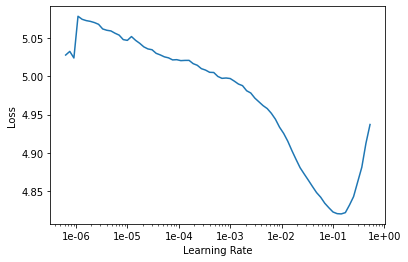

In [24]:
learn_model.recorder.plot(skip_end=15) # to plot the LR

In [0]:
lr = 1e-2
lr *= bs/48

In [26]:
learn_model.fit_one_cycle(1, 1e-2, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,3.846271,3.716349,0.394125,08:47


Now we unfreeze the layers, not just one as in the previous step

In [0]:
learn_model.unfreeze()

In [28]:
learn_model.fit_one_cycle(10, lr, moms=(0.8,0.7), wd=0.1)  # we can adjust the learning rate and run the model again if required

epoch,train_loss,valid_loss,accuracy,time
0,3.658939,3.610447,0.407588,10:10
1,3.900976,3.820876,0.389882,10:09
2,3.988875,3.912119,0.382812,10:09
3,3.940277,3.860862,0.386535,10:09
4,3.878322,3.803739,0.391520,10:10
5,3.776120,3.700991,0.401105,10:10
6,3.640770,3.592224,0.410946,10:09
7,3.497311,3.468571,0.423438,10:10
8,3.281701,3.382878,0.433480,10:10
9,3.075202,3.373697,0.434912,10:09


In [0]:
#learn_model.fit_one_cycle(1, lr*10, moms=(0.8,0.7))

Now we will save just the encoder which will be later used for classification

In [0]:
learn_model.save_encoder('fwd_enc')
#learn_lm.save('fit_1')  # saving the fine tuned language model
#learn_lm.load('fit_1')

Backwards model

You can't directly train a bidirectional RNN for language modeling, but you can always enseble a forward and backward model. fastai provides a pretrained forward and backawrd model, so we can repeat the previous step to fine-tune the pretrained backward model. The command language_model_learner checks the data object you pass to automatically decide if it should use the pretrained forward or backward model.

In [30]:
learn_model = language_model_learner(data_bwd, AWD_LSTM,drop_mult=0.3)

In [31]:
learn_model.fit_one_cycle(1, lr, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,3.867663,3.715333,0.425850,08:50


In [0]:
learn_model.unfreeze()

In [33]:
learn_model.fit_one_cycle(10, lr, moms=(0.8,0.7),wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,3.644809,3.595366,0.439338,10:10
1,3.888639,3.809960,0.422575,10:09
2,3.973485,3.888426,0.414317,10:09
3,3.938116,3.853100,0.417584,10:10
4,3.864467,3.786871,0.424581,10:10
5,3.758890,3.693187,0.432540,10:10
6,3.649447,3.586125,0.442901,10:10
7,3.498498,3.465934,0.454821,10:09
8,3.278994,3.380776,0.464244,10:09
9,3.083931,3.371076,0.465724,10:09


In [0]:
learn_model.save_encoder('bwd_enc')

In [0]:
vocab = data_lm.vocab

In [36]:
vocab.stoi["stingray"]


23100

In [0]:
awd = learn_model.model[0]

In [38]:
enc = learn_model.model[0].encoder
enc.weight.size()

torch.Size([48368, 400])

In [39]:
vocab.stoi["trump"]

52

In [0]:
TEXT = "Trump is"
N_WORDS = 30
N_SENTENCES = 1

In [41]:
print("\n".join(learn_model.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))  #wont make sense since this is the output from the backward model

Trump is , " ? " trump President ? spot expensive most 's trump With on going 's what so . really , well ? election


In [42]:
learn_model.predict("This is a review about", n_words=20)

'This is a review about professed who woman international an , memoir the of author , tripping Sally To goes product the'

Classifier

In [0]:
bs=32

In [44]:
data_clas.show_batch()

text,target
"xxbos xxmaj sunday xxmaj roundup xxmaj this week the nation came one step closer to giving itself over to the most dangerous and unstable potential leader in xxup u.s. history , as xxmaj donald xxmaj trump "" humbly "" accepted the xxmaj republican presidential nomination - so humbly , in fact , that he went on to claim that "" i alone can fix "" xxmaj america . xxmaj it",POLITICS
"xxbos xxmaj weekend xxmaj roundup xxmaj this week , while the xxup u.s. celebrates its independence , the world watches a modern xxmaj greek tragedy unfold as xxmaj greece votes on austere bailout terms imposed by the country 's creditors . xxmaj however the vote goes , one thing is clear : xxmaj the austerity that came with the two previous bailouts has utterly broken the xxmaj greek economy .",POLITICS
"xxbos xxmaj what xxmaj to xxmaj do xxmaj when xxmaj you 're a xxmaj pregnant xxmaj bridesmaid ( xxup photos ) xxmaj imagine that your closest friend or sister is engaged and wants you to be her bridesmaid . xxmaj after thanking her for the honor ( and asking who else will be a bridesmaid ) , you begin to wonder what you 're going to have to wear .",STYLE & BEAUTY
"xxbos xxmaj sunday xxmaj roundup xxmaj this week was dominated by news from xxmaj ferguson -- but much of what was really happening went untold by the media . xxmaj while xxup tv viewers were mostly presented with endless images of tear gas , violence and division , a fuller depiction would have revealed a community challenged by adversity , xxunk and institutional failure that responded with remarkable empathy ,",POLITICS
xxbos xxmaj the xxmaj impending ' xxmaj peaceful xxmaj war ' xxmaj between xxmaj china and xxmaj america xxmaj over xxmaj xxunk xxmaj unlike the xxmaj cold xxmaj war period -- in which the xxmaj soviet xxmaj union was isolated from the global economy -- commercial interests and trade secrets underpin the intrinsically entangled xxmaj sino - xxmaj american economic relations . xxmaj the xxunk - xxunk distinction between national,WORLD NEWS


In [0]:
data_clas_bwd = load_data(path, 'data_clas_export.pkl', bs=bs, backwards=True)   #loading data for the backward classifier

In [46]:
data_clas_bwd.show_batch()

text,target
". hearts and minds our in but polls the at only not - reject must we bet the 's that and xxmaj . bet his 's that xxmaj . america xxmaj shorting , essence in , is trump xxmaj . fear of nurturing cynical and manipulation the but fear to nothing have we , fdr xxup paraphrase to , but xxmaj . minds our in place that building by wins",POLITICS
". size hand to unrelated is responsibility of sense 's one apparently but , party of ahead country putting for much so xxmaj . problem no , sure , yeah xxmaj , effect in , said candidates other the of three all nominee as him support 'd they if asked when , country the to danger a and fraud a as trump xxmaj attacking after xxmaj . end the at",POLITICS
". street xxmaj wall xxmaj by paid highly , fact in , is he that disclosing without often , loves street xxmaj wall xxmaj that policies advocated long has hubbard xxmaj : huge are interest of conflicts those , least not but last and xxmaj . interest of conflicts own his and issues policy both discussing when dishonest even and , misleading , evasive been has hubbard xxmaj , experience",BUSINESS
". sponsors street xxmaj wall xxmaj her to acceptable be will that one the and wage to needs clinton xxmaj campaign the between fight the is watch to contest the , no xxmaj . rivals republican xxmaj her and clinton xxmaj between campaign likely the even or nomination the for battle the not is come to contest political interesting most the , ways many in xxmaj . specific very getting",POLITICS
". up ice n't do lighthouses the so , suppressed are spray and splashing the and , over freeze to tends michigan xxmaj lake xxmaj and , later any xxmaj . liquid still is lake the and , windy , xxunk icing for time typical the is december xxmaj late to mid , rule a as xxmaj . ice in covered completely was michigan xxmaj , joseph xxmaj st. xxmaj",ENVIRONMENT


Fine tuning the forward classifier

The classifier needs a little less dropout, so we pass drop_mult=0.5 to multiply all the dropouts by this amount (it's easier than adjusting all the five different values manually). We don't load the pretrained model, but instead our fine-tuned encoder from the previous section.

In [47]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn.load_encoder('fwd_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (144438 items)
x: TextList
xxbos xxmaj luke xxmaj from ' xxmaj gilmore xxmaj girls ' xxmaj is xxmaj getting xxmaj his xxmaj own xxmaj line xxmaj of xxmaj coffee xxmaj we have a feeling xxmaj lorelai would 've loved this .,xxbos xxmaj the xxmaj huffington xxmaj post xxmaj is xxmaj hiring a xxmaj tech xxmaj reporter xxmaj the ideal candidate will have at least three years of experience writing for major publications and a demonstrated interest in gadgets , tech business , the future of our planet and sustainability .,xxbos xxmaj simple xxmaj greek : xxmaj baked xxmaj sardines xxmaj from xxmaj diane xxmaj kochilas xxmaj diane xxmaj kochilas of xxmaj molyvos gives her advice for cooking xxmaj greek food -- such as ingredients like olives , oregano , fennel , feta cheese and citrus -- and then she showcases a traditional recipe from xxmaj lesvos , baked sardines . xxmaj she shows us how to make baked sardines and explains why it is such a

In [48]:
data_clas.show_batch()

text,target
"xxbos xxmaj sunday xxmaj roundup xxmaj this week the nation came one step closer to giving itself over to the most dangerous and unstable potential leader in xxup u.s. history , as xxmaj donald xxmaj trump "" humbly "" accepted the xxmaj republican presidential nomination - so humbly , in fact , that he went on to claim that "" i alone can fix "" xxmaj america . xxmaj it",POLITICS
"xxbos xxmaj weekend xxmaj roundup : xxmaj greece xxmaj revolts ! xxmaj no sooner did the global elites leave their annual talking shop high in the xxmaj alps at xxmaj davos last week than the people spoke in xxmaj greece . xxmaj in a mutiny against an untenable status quo , those who are run over have revolted against those who run things . xxmaj now righteous populism must face",WORLD NEWS
"xxbos xxmaj weekend xxmaj roundup : a xxmaj pattern of xxmaj crises xxmaj connects xxmaj cologne and xxmaj istanbul xxmaj even before the "" xxmaj night of xxmaj shame "" on xxmaj new xxmaj year 's xxmaj eve in xxmaj cologne further fueled an already fervent anti - foreigner backlash , xxmaj german leaders were desperately looking to xxmaj turkey to stem the flow of refugees headed to xxmaj europe",WORLD NEWS
xxbos xxmaj sunday xxmaj roundup xxmaj happy 4th of xxmaj july weekend ! xxmaj the week leading up to the holiday gave us much to celebrate -- and much not to celebrate . xxmaj we can certainly rejoice that xxmaj hurricane xxmaj arthur failed to do much damage before weakening and heading out to sea . xxmaj but there can only be consternation at the xxmaj supreme xxmaj court 's,POLITICS
"xxbos xxmaj as a xxmaj millennial : xxmaj these are ( some of ) my issues for the xxmaj upcoming xxmaj election xxmaj part xxup ii xxmaj even more important , is for presidential candidates to take the campaigning process seriously . xxmaj as xxmaj florida xxmaj senator xxmaj marco xxmaj rubio pointed out earlier this week , "" this is n't joke , this is serious "" , and",POLITICS


In [49]:
lr = 1e-2
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,1.251260,1.114925,0.675978,02:29


In [50]:
learn.freeze_to(-2)
lr /= 2
learn.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,1.127856,1.016343,0.704696,02:45


In [0]:
learn.save('last2')

In [52]:
learn.load('last2')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (144438 items)
x: TextList
xxbos xxmaj luke xxmaj from ' xxmaj gilmore xxmaj girls ' xxmaj is xxmaj getting xxmaj his xxmaj own xxmaj line xxmaj of xxmaj coffee xxmaj we have a feeling xxmaj lorelai would 've loved this .,xxbos xxmaj the xxmaj huffington xxmaj post xxmaj is xxmaj hiring a xxmaj tech xxmaj reporter xxmaj the ideal candidate will have at least three years of experience writing for major publications and a demonstrated interest in gadgets , tech business , the future of our planet and sustainability .,xxbos xxmaj simple xxmaj greek : xxmaj baked xxmaj sardines xxmaj from xxmaj diane xxmaj kochilas xxmaj diane xxmaj kochilas of xxmaj molyvos gives her advice for cooking xxmaj greek food -- such as ingredients like olives , oregano , fennel , feta cheese and citrus -- and then she showcases a traditional recipe from xxmaj lesvos , baked sardines . xxmaj she shows us how to make baked sardines and explains why it is such a

In [53]:
learn.freeze_to(-3)
lr /= 2
learn.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,1.059443,0.947615,0.720154,04:30


In [0]:
learn.save('last3')

In [55]:
learn.load('last3')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (144438 items)
x: TextList
xxbos xxmaj luke xxmaj from ' xxmaj gilmore xxmaj girls ' xxmaj is xxmaj getting xxmaj his xxmaj own xxmaj line xxmaj of xxmaj coffee xxmaj we have a feeling xxmaj lorelai would 've loved this .,xxbos xxmaj the xxmaj huffington xxmaj post xxmaj is xxmaj hiring a xxmaj tech xxmaj reporter xxmaj the ideal candidate will have at least three years of experience writing for major publications and a demonstrated interest in gadgets , tech business , the future of our planet and sustainability .,xxbos xxmaj simple xxmaj greek : xxmaj baked xxmaj sardines xxmaj from xxmaj diane xxmaj kochilas xxmaj diane xxmaj kochilas of xxmaj molyvos gives her advice for cooking xxmaj greek food -- such as ingredients like olives , oregano , fennel , feta cheese and citrus -- and then she showcases a traditional recipe from xxmaj lesvos , baked sardines . xxmaj she shows us how to make baked sardines and explains why it is such a

In [56]:
learn.unfreeze()
lr /= 5
learn.fit_one_cycle(10, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.975720,0.936779,0.723606,06:09
1,0.952977,0.929297,0.726784,06:27
2,0.936199,0.916819,0.730668,06:28
3,0.909337,0.906673,0.732983,05:57
4,0.852579,0.905054,0.734552,06:05
5,0.841902,0.902857,0.736788,06:30
6,0.793678,0.902617,0.735965,06:25
7,0.732816,0.900760,0.738240,05:53
8,0.687144,0.904889,0.738397,06:30
9,0.724657,0.901386,0.738358,05:47


In [0]:
learn.save('fwd_clas')

In [58]:
preds,targs = learn.get_preds(ordered=True)

In [59]:
accuracy(preds,targs)

tensor(0.7384)

In [60]:
learn.load('fwd_clas')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (144438 items)
x: TextList
xxbos xxmaj luke xxmaj from ' xxmaj gilmore xxmaj girls ' xxmaj is xxmaj getting xxmaj his xxmaj own xxmaj line xxmaj of xxmaj coffee xxmaj we have a feeling xxmaj lorelai would 've loved this .,xxbos xxmaj the xxmaj huffington xxmaj post xxmaj is xxmaj hiring a xxmaj tech xxmaj reporter xxmaj the ideal candidate will have at least three years of experience writing for major publications and a demonstrated interest in gadgets , tech business , the future of our planet and sustainability .,xxbos xxmaj simple xxmaj greek : xxmaj baked xxmaj sardines xxmaj from xxmaj diane xxmaj kochilas xxmaj diane xxmaj kochilas of xxmaj molyvos gives her advice for cooking xxmaj greek food -- such as ingredients like olives , oregano , fennel , feta cheese and citrus -- and then she showcases a traditional recipe from xxmaj lesvos , baked sardines . xxmaj she shows us how to make baked sardines and explains why it is such a

Same thing backwards

Then we do the same thing for the backward model, the only thigns to adjust are the names of the data object and the fine-tuned encoder we load.

In [61]:
learn_bwd = text_classifier_learner(data_clas_bwd, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn_bwd.load_encoder('bwd_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (144438 items)
x: TextList
xxbos xxmaj luke xxmaj from ' xxmaj gilmore xxmaj girls ' xxmaj is xxmaj getting xxmaj his xxmaj own xxmaj line xxmaj of xxmaj coffee xxmaj we have a feeling xxmaj lorelai would 've loved this .,xxbos xxmaj the xxmaj huffington xxmaj post xxmaj is xxmaj hiring a xxmaj tech xxmaj reporter xxmaj the ideal candidate will have at least three years of experience writing for major publications and a demonstrated interest in gadgets , tech business , the future of our planet and sustainability .,xxbos xxmaj simple xxmaj greek : xxmaj baked xxmaj sardines xxmaj from xxmaj diane xxmaj kochilas xxmaj diane xxmaj kochilas of xxmaj molyvos gives her advice for cooking xxmaj greek food -- such as ingredients like olives , oregano , fennel , feta cheese and citrus -- and then she showcases a traditional recipe from xxmaj lesvos , baked sardines . xxmaj she shows us how to make baked sardines and explains why it is such a

In [62]:
lr = 1e-2
learn_bwd.fit_one_cycle(1, lr, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,1.610163,1.376194,0.610577,02:49


In [63]:
learn_bwd.freeze_to(-2)
lr /= 2
learn_bwd.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,1.249493,1.073496,0.691789,03:20


In [0]:
learn_bwd.save('twolayers_bwd')

In [0]:
learn_bwd.load('twolayers_bwd')

In [66]:
learn_bwd.freeze_to(-3)
lr /= 2
learn_bwd.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,1.058453,0.972882,0.717054,05:32


In [0]:
learn_bwd.save('threelayer_bwd')

In [0]:
learn_bwd.load('threelayer_bwd')

In [69]:
learn_bwd.unfreeze()
lr /= 5
learn_bwd.fit_one_cycle(10, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.980517,0.961231,0.720664,07:06
1,0.996031,0.946244,0.724783,07:39
2,0.958775,0.931075,0.727765,07:23
3,0.920023,0.927698,0.731139,07:14
4,0.896530,0.914094,0.734317,07:23
5,0.875249,0.909889,0.738397,07:19
6,0.767028,0.904272,0.742046,07:00
7,0.760504,0.913675,0.742438,07:22
8,0.737534,0.905788,0.743183,07:16
9,0.710762,0.905992,0.743536,07:42


In [70]:
preds_bwd,targs_bwd = learn_bwd.get_preds(ordered=True)
accuracy(preds_bwd,targs_bwd)

tensor(0.7435)

In [0]:
learn_bwd.save('bwd_clas')

Ensembling the two models


For our final results, we'll take the average of the predictions of the forward and the backward models. SInce the samples are sorted by text lengths for batching, we pass the argument ordered=True to get the predictions in the order of the texts.

In [72]:
pred_fwd,lbl_fwd = learn.get_preds(ordered=True)

In [73]:
pred_bwd,lbl_bwd = learn_bwd.get_preds(ordered=True)

In [0]:
final_pred = (pred_fwd+pred_bwd)/2

In [75]:
accuracy(final_pred, lbl_fwd)
#tensor(0.7516)

tensor(0.7516)